# Extração e seleção de características

As características que são extraídas dos dados dependem de sua natureza. Os dados EMG são sinais elétricos coletados dentro de um período de tempo, portanto são dados no domínio do tempo. As características deste domínio são extraídas dele. Também é possível transformar os dados EMG para o domínio da frequência e extrair características neste domínio. Existem diversas características que podem ser extraídas de cada domínio, entretando nem todas elas serão relevantes. Cada problema se beneficia de características ou combinações delas. Portanto, é preciso que haja uma seleção de características para encontrar a combinação de características que trará melhor resultado na posterior classificação dos dados.

## Reutilizando os passos anteriores

É necessário carregar os dados pré-processados, para dar início à extração de características. No jupyter notebook podemos utilizar o namespace completo de outro notebook:

In [1]:
%run preprocessing.ipynb

(20000, 2)
(10, 6, 20000, 2) - (classes, ensaios, linhas, canais)
(10, 6, 2, 20000) - (classes, ensaios, canais, linhas)
 (60, 2, 20000)
Formato (shape) dos dados depois da divisão de janelas
Dominio do tempo: (60, 2, 41, 1024) - (classes+ensaios, canais, janelas, linhas)
Dominio da frequência:  (60, 2, 41, 513) - (classes+ensaios, canais, janelas, linhas)


Uma característica é uma propriedade individual mensurável ou característica de um fenômeno que está sendo observado. Em EMG, uma característica pode ser extraída no domínio do tempo ou no domínio da frequência. As características a seguir foram retiradas do artigo *EMG Feature Extraction for Tolerance of White Gaussian Noise* \[1\].

### Domínio do tempo

1. Willison Amplitude (WAMP)

    > $ \sum_{i=1}^{N-1}f(|x_i - x_{i+1}|) $
    
    > $ f(x) = \begin{cases} 1 & \text{if } x \gt threshold \\ 0 & \text{otherwise} \end{cases} $

2. Variance of EMG (VAR)

    > $ \frac{1}{N-1}\sum_{i=1}^{N}x_i^2 $

3. Root Mean Square (RMS)

    > $ \sqrt{\frac{1}{N}\sum_{i=1}^{N}|x_i|^2} $

4. Waveform Length (WL)
    
    > $ \sum_{i=1}^{N-1}|x_{i+1} - x_i| $

5. Zero Crossing (ZC)

    > $ \sum_{i=1}^{N}sgn([x_i - threshold][x_{i+1} - threshold]) $
    
    > $ sgn(x) = \begin{cases} 1 & \text{if } x \gt threshold \\ 0 & \text{otherwise} \end{cases} $
    
    > $ threshold = mediana $

### Domínio da frequência

1. Median Frequency (FMD)

    > $ \frac{1}{2}\sum_{j=1}^{M}PSD_j $

2. Mean Frequency (FMN)

    > $ \sum_{j=1}^{M}f_j PSD_j \Big{/} \sum_{j=1}^{M}PSD_j $
    
    > $ f_j = j * SampleRate \Big{/} 2 * M $

3. Modified Median Frequency (MMDF)

    > $ \frac{1}{2}\sum_{j=1}^{M}A_j $
    
    > $ A_j = Amplitude\ do\ espectro\ j $

4. Modified Frequency Mean (MMNF)

    > $ \sum_{j=1}^{M}f_jAj \Big{/} \sum_{j=1}^{M}Aj $


\[1\] Phinyomark, Angkoon & Limsakul, Chusak & Phukpattaranont, P.. (2008). EMG Feature Extraction for Tolerance of White Gaussian Noise.
[Disponível neste link](https://www.researchgate.net/publication/263765853_EMG_Feature_Extraction_for_Tolerance_of_White_Gaussian_Noise)

**Desafio 1**: Descrever as características de acordo com o artigo citado e outros disponíveis relacionados. O que está querendo "ser visto" em cada característica? Qual é o significado matemático de cada uma delas?

- WAMP:

    Amplitude de Willison.
    
    Quantidade de alterações na amplitude do sinal qe excederam um limite.

    Representa o nível de contração muscular.


- VAR:

    Variancia do sinal.

    Detecta a força muscular.
    

- RMS: 

    Raiz quadrada média.

    É o desvio padrão.

    Detecta força constante e contração não fatigante.


- WL:

    Cumprimento de forma de onda.

    É a amplituda da forma de onda.


- ZC:

    Cruzamento zero.

    É a mudança de sinal de inclinação. Quantas vezes os sinais cruzam o zero.


- FMD:

    Frequência mediana.

    É a frequência em que o espectro é dividido em duas regiãos de poder igual.

- FMN:

    Frequência média.

    É a soma do produto do espectro de potência e a frequência, dividido pela soma da intensidade do espectograma.


- MMDF:
    
    Frequência Mediana Modificada

    É a frequência na qual o espectro é dividido em duas regiões com amplitude igual.

- MMNF:

    Média da frequência modificada.

    É calculado como a soma do produto do espectro de amplitude e a frequência, dividido pela soma total da intensidade do espectro.



### Extraindo características

É necessário implementar as características, geralmente em formato de funções ou métodos, para que seja possível aplicar tais funções aos dados de entrada e obter as características resultantes. A seguir temos a implementação das características VAR & RMS (domínio do tempo) e FDM & MMDF (domínio da frequência).

In [2]:
from math import prod

# funções auxiliares
def PSD(w):
    ''' definição da função PSD para o sinal no domínio da frequência '''
    return np.abs(w) ** 2


# funções de extração de características

def var(x):
    return np.sum(x ** 2, axis=-1) / (np.prod(x.shape[:-1]) - 1)

def rms(x):
    return np.sqrt(np.sum(np.abs(x) ** 2, axis=-1) / (np.prod(x.shape[:-1])))

def wamp(x):
    limiar = np.abs(np.diff(x))
    return np.sum(limiar > 0.4, axis=-1)

def wl(x):
    return np.sum(np.abs(np.diff(x)), axis=-1)

def zc(x):
    trs = 0.4
 
    f = [1 if i*j <= 0 else 0 for i,j in zip(x[:,:,:,:-1], x[:,:,:,1:])]
    
    return np.sum(f)


def fmd(w):
    return np.sum(PSD(w), axis=-1) / 2

def mmdf(w):
    return np.sum(np.abs(w), axis=-1) / 2


def fmn(w):
    sample_rate = 4000
    f = (w * sample_rate)/(2*len(w))
    return np.sum(f*PSD(w), axis=-1)/np.sum(PSD(w), axis=-1)

def mmnf(w):
    sample_rate = 4000
    f = (w * sample_rate)/(2*len(w))
    return np.sum(f*np.abs(w), axis=-1)/np.sum(np.abs(w), axis=-1)

**Desafio 2**: Implemente todas as características apresentadas neste tutorial em formato de funções. Sinta-se livre também para buscar e implementar características EMG além das apresentadas, citando as fontes de tais características.


## Vetor de características

Ao final da implementação e seleção das características, deve ser escolhida as características e então teremos um vetor com todas elas implementadas.

O vetor de características estará organizado da seguinte forma (exemplo p/ VAR, RMS, RDM e MMDF):

| ID sample | VAR1 | RMS1 | FMD1 | MMDF1 | VAR2 | RMS2 | FMD2 | MMDF2 | Classe |
|:---------:|:----:|:----:|:----:|:-----:|------|------|------|-------|:------:|
|     1     |  v1  |  v1  |  v1  |   v1  | v1   | v1   | v1   | v1    |    0   |
|     2     |  v2  |  v2  |  v2  |   v2  | v2   | v2   | v2   | v2    |    0   |
|    ...    |  ... |  ... |  ... |  ...  | ...  | ...  | ...  | ...   |   ...  |
|     N     |  vN  |  vN  |  vN  |   vN  | vN   | vN   | vN   | vN    |    7   |

## Implementação do vetor

In [3]:
final_data = list()
final_data.append(var(chunks_time))
final_data.append(rms(chunks_time))
final_data.append(fmd(chunks_freq))
final_data.append(mmdf(chunks_freq))

final_data.append(wamp(chunks_time))
final_data.append(wl(chunks_time))
# final_data.append(zc(chunks_time))
final_data.append(fmn(chunks_freq))
final_data.append(mmnf(chunks_freq))


final = np.array(final_data)
final.shape

(8, 60, 2, 41)

É necessário que seja reordenado as dimensões do vetor de características, pois cada característica (de cada canal), deve corresponder à última dimensão do vetor. Por fim, as outras dimensões são concatenadas para o número de amostras.

In [4]:
data = final.transpose(1, 3, 2, 0)
X = data.reshape(data.shape[0]*data.shape[1], data.shape[2]*data.shape[3])
X.shape

(2460, 16)

## Seleção de características

Nesta etapa, são selecionadas as características que mais afetam positivamente no resultado final da classificação. Vamos estudar os métodos de seleção de características nesta [página do projeto sklearn](https://scikit-learn.org/stable/modules/feature_selection.html).

**Desafio 3**: mostrar o resultado para os dados de trabalho, para os seguintes métodos se leção de características:
- VarianceThreshold
- Univariate feature selection
    - escolha o que mais for "interessante": `SelectKBest`, `SelectPercentile` e `GenericUnivariateSelect`
- Recursive feature elimination

In [5]:
X

array([[ 1.18013064e-08+0.00000000e+00j,  1.08622777e-04+0.00000000e+00j,
         6.77450315e-09+0.00000000e+00j, ...,
         1.51831655e-02+0.00000000e+00j, -5.34920907e-06+1.29334326e-05j,
        -1.03374574e-06+3.37498610e-06j],
       [ 1.65546043e-08+0.00000000e+00j,  1.28651621e-04+0.00000000e+00j,
         2.44195066e-08+0.00000000e+00j, ...,
         1.65924260e-02+0.00000000e+00j,  4.31540025e-05+5.86385910e-05j,
         1.45160986e-05+1.65734339e-05j],
       [ 1.93659343e-08+0.00000000e+00j,  1.39147397e-04+0.00000000e+00j,
         3.83861869e-08+0.00000000e+00j, ...,
         1.75013536e-02+0.00000000e+00j,  2.78451452e-06+8.99093860e-06j,
         3.03312178e-08+4.38762415e-06j],
       ...,
       [ 4.36418225e-08+0.00000000e+00j,  2.08885022e-04+0.00000000e+00j,
         3.71419247e-08+0.00000000e+00j, ...,
         4.65579455e-02+0.00000000e+00j, -6.18235775e-05+6.99482155e-05j,
        -9.21113620e-06+1.72038188e-05j],
       [ 3.48318810e-08+0.00000000e+00j,  1.

In [6]:
X[:,0]

array([1.18013064e-08+0.j, 1.65546043e-08+0.j, 1.93659343e-08+0.j, ...,
       4.36418225e-08+0.j, 3.48318810e-08+0.j, 2.51140483e-08+0.j])

In [7]:
X = np.real(X)
X

array([[ 1.18013064e-08,  1.08622777e-04,  6.77450315e-09, ...,
         1.51831655e-02, -5.34920907e-06, -1.03374574e-06],
       [ 1.65546043e-08,  1.28651621e-04,  2.44195066e-08, ...,
         1.65924260e-02,  4.31540025e-05,  1.45160986e-05],
       [ 1.93659343e-08,  1.39147397e-04,  3.83861869e-08, ...,
         1.75013536e-02,  2.78451452e-06,  3.03312178e-08],
       ...,
       [ 4.36418225e-08,  2.08885022e-04,  3.71419247e-08, ...,
         4.65579455e-02, -6.18235775e-05, -9.21113620e-06],
       [ 3.48318810e-08,  1.86614044e-04,  3.00829112e-08, ...,
         4.68359992e-02,  1.08809455e-05,  2.42856935e-06],
       [ 2.51140483e-08,  1.58458019e-04,  1.97532373e-14, ...,
         4.27082798e-02,  2.10451945e-09,  8.33790712e-10]])

In [10]:
y = np.array(list(range(1, 11)) * int(X.shape[0] / 10))

In [17]:
y[:15]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  1,  2,  3,  4,  5])

In [8]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold()
selector.fit_transform(X)
# data[data.columns[selector.get_support(indices=True)]]

array([[ 1.18013064e-08,  1.08622777e-04,  6.77450315e-09, ...,
         1.51831655e-02, -5.34920907e-06, -1.03374574e-06],
       [ 1.65546043e-08,  1.28651621e-04,  2.44195066e-08, ...,
         1.65924260e-02,  4.31540025e-05,  1.45160986e-05],
       [ 1.93659343e-08,  1.39147397e-04,  3.83861869e-08, ...,
         1.75013536e-02,  2.78451452e-06,  3.03312178e-08],
       ...,
       [ 4.36418225e-08,  2.08885022e-04,  3.71419247e-08, ...,
         4.65579455e-02, -6.18235775e-05, -9.21113620e-06],
       [ 3.48318810e-08,  1.86614044e-04,  3.00829112e-08, ...,
         4.68359992e-02,  1.08809455e-05,  2.42856935e-06],
       [ 2.51140483e-08,  1.58458019e-04,  1.97532373e-14, ...,
         4.27082798e-02,  2.10451945e-09,  8.33790712e-10]])

In [11]:
from sklearn.feature_selection import SelectKBest

X_new = SelectKBest(k=5)
X_new.fit_transform(X,y)
# X_new.feature_names_in_

/home/luisotavio/.local/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 4 12] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/luisotavio/.local/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


array([[ 6.77450315e-09, -2.19255076e-05, -7.09062848e-06,
         6.71193684e-10,  1.51831655e-02],
       [ 2.44195066e-08, -4.12060002e-05, -2.40040809e-05,
         8.25168345e-10,  1.65924260e-02],
       [ 3.83861869e-08, -1.37279217e-04, -3.15881029e-05,
         9.49938587e-10,  1.75013536e-02],
       ...,
       [ 3.71419247e-08, -1.45826107e-05,  1.10308203e-05,
         8.37222149e-09,  4.65579455e-02],
       [ 3.00829112e-08,  5.42897382e-05,  1.74434064e-05,
         9.10160853e-09,  4.68359992e-02],
       [ 1.97532373e-14, -6.59086878e-09, -2.04121125e-09,
         7.25901078e-09,  4.27082798e-02]])

In [19]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVC

estimator = SVC(kernel='linear')

selector = RFE(estimator, n_features_to_select=5, step=1)

selector = selector.fit_transform(X,y)
selector
# selector.feature_names_in_

array([[ 5.62231411e-04,  6.80664130e-02, -2.19255076e-05,
         1.31113978e-04,  1.51831655e-02],
       [ 1.00414068e-03,  7.36748266e-02, -4.12060002e-05,
         2.14729409e-04,  1.65924260e-02],
       [ 1.19850953e-03,  7.49454829e-02, -1.37279217e-04,
         2.72555549e-04,  1.75013536e-02],
       ...,
       [ 1.04108269e-03,  9.30560410e-02, -1.45826107e-05,
         6.33315154e-04,  4.65579455e-02],
       [ 1.03131990e-03,  8.30985797e-02,  5.42897382e-05,
         5.89220008e-04,  4.68359992e-02],
       [ 1.39476118e-06,  7.06532971e-02, -6.59086878e-09,
         3.44956831e-07,  4.27082798e-02]])

In [20]:
np.array(selector).shape

(2460, 5)

In [23]:
X.shape

(2460, 16)

In [24]:
y.shape

(2460,)

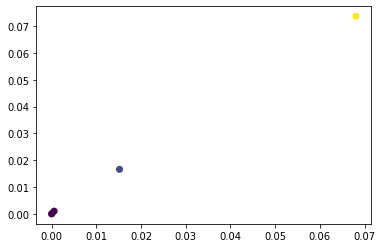

In [37]:
import matplotlib.pyplot as plt

plt.scatter(selector[0],selector[1], c=selector[1])
plt.show()

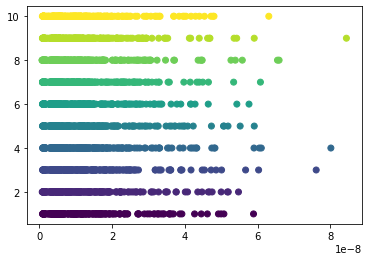

In [42]:
plt.scatter(X[:,0],y, c=y)
plt.show()